In [4]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import datetime as dt
import time
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pywt
from deap import base, creator, tools, algorithms
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score
import talib
from xgboost import XGBRegressor
import seaborn as sns

In [5]:
data = pd.read_csv('BTCUSDT_PERPETUAL.csv', parse_dates=True, index_col='open_time')
data

,open,high,low,close,volume,close_time,quote_volume,trades_num,taker_buy_volume,taker_buy_quote_volume
open_time,,,,,,,,,,
2020-12-31 16:00:00,28792.58,28837.77,28782.46,28832.70,293.514,2020-12-31 16:00:59.999,8.456309e+06,2280,159.698,4.601449e+06
2020-12-31 16:01:00,28832.69,28836.72,28733.12,28746.85,313.979,2020-12-31 16:01:59.999,9.037019e+06,2529,70.785,2.037393e+06
2020-12-31 16:02:00,28748.05,28760.00,28700.47,28715.85,350.483,2020-12-31 16:02:59.999,1.006867e+07,2600,109.508,3.146607e+06
2020-12-31 16:03:00,28714.66,28739.75,28706.00,28711.42,199.614,2020-12-31 16:03:59.999,5.733296e+06,1514,75.826,2.178253e+06
2020-12-31 16:04:00,28711.43,28749.21,28700.00,28735.53,225.339,2020-12-31 16:04:59.999,6.471661e+06,1767,116.240,3.339144e+06
...,...,...,...,...,...,...,...,...,...,...
2024-03-26 23:55:00,70126.20,70126.20,70085.90,70086.00,48.272,2024-03-26 23:55:59.999,3.384086e+06,956,23.199,1.626346e+06
2024-03-26 23:56:00,70085.90,70121.00,70068.40,70109.80,50.604,2024-03-26 23:56:59.999,3.547237e+06,1071,39.824,2.791659e+06
2024-03-26 23:57:00,70109.70,70109.80,70042.50,70042.90,42.607,2024-03-26 23:57:59.999,2.985270e+06,846,17.339,1.214848e+06


In [6]:
data = data.rename(columns={'Open': 'open', 'High': 'high', 'Low': 'low', 'Close': 'close', 'Volume': 'volume'})

In [7]:
data = data.drop(data.columns[data.columns.get_loc('volume')+1:], axis=1)
data

,open,high,low,close,volume
open_time,,,,,
2020-12-31 16:00:00,28792.58,28837.77,28782.46,28832.70,293.514
2020-12-31 16:01:00,28832.69,28836.72,28733.12,28746.85,313.979
2020-12-31 16:02:00,28748.05,28760.00,28700.47,28715.85,350.483
2020-12-31 16:03:00,28714.66,28739.75,28706.00,28711.42,199.614
2020-12-31 16:04:00,28711.43,28749.21,28700.00,28735.53,225.339
...,...,...,...,...,...
2024-03-26 23:55:00,70126.20,70126.20,70085.90,70086.00,48.272
2024-03-26 23:56:00,70085.90,70121.00,70068.40,70109.80,50.604
2024-03-26 23:57:00,70109.70,70109.80,70042.50,70042.90,42.607


In [8]:
rule = '4h'

d1 = data.resample(rule=rule, closed='left', label='left').first()[['open']]
d2 = data.resample(rule=rule, closed='left', label='left').max()[['high']]
d3 = data.resample(rule=rule, closed='left', label='left').min()[['low']]
d4 = data.resample(rule=rule, closed='left', label='left').last()[['close']]
d5 = data.resample(rule=rule, closed='left', label='left').sum()[['volume']]

df = pd.concat([d1,d2,d3,d4,d5], axis=1)
df['return'] = df['close'].pct_change()
df.dropna(inplace = True)
df

,open,high,low,close,volume,return
open_time,,,,,,
2020-12-31 20:00:00,28917.08,29199.49,28800.00,28951.68,25067.611,0.001197
2021-01-01 00:00:00,28948.19,29546.42,28706.00,29302.11,43210.161,0.012104
2021-01-01 04:00:00,29302.11,29422.32,28822.00,29107.71,26682.086,-0.006634
2021-01-01 08:00:00,29107.72,29454.45,28900.00,29341.99,29562.630,0.008049
2021-01-01 12:00:00,29342.00,29668.86,29043.75,29210.84,49142.952,-0.004470
...,...,...,...,...,...,...
2024-03-26 04:00:00,70473.70,71649.00,70302.40,70535.00,50356.280,0.000868
2024-03-26 08:00:00,70535.00,71340.80,70295.90,70734.20,44137.268,0.002824
2024-03-26 12:00:00,70734.10,71200.00,69320.00,70307.10,101981.595,-0.006038


In [9]:
def calculate_technical_indicators(df):
    df = df.copy()
    close = df['close']
    high = df['high']
    low = df['low']
    volume = df['volume']
    
    # MACD and Signal Line High
    df['MACD'], df['Signal Line'], _ = talib.MACD(close)
    df['MACD_High'] = df[['MACD', 'Signal Line']].max(axis=1)
    
    # MACD Histogram Low
    df['MACD_Histogram'] = talib.MACD(close)[2]
    df['MACD_Histogram_Low'] = df['MACD_Histogram'].min()
    
    # PPO Adj. Close
    df['PPO'] = talib.PPO(close)
    
    # ADX Volume
    df['ADX'] = talib.ADX(high, low, close)
    df['Volume_ADX'] = talib.SMA(volume, timeperiod=14)
    
    # Momentum
    df['Momentum'] = close - close.shift(10)
    
    # CCI
    df['CCI'] = talib.CCI(high, low, close, timeperiod=20)
    
    # ROC
    df['ROC'] = talib.ROC(close, timeperiod=10)
    
    # Stochastic %D and %K
    df['%K'], df['%D'] = talib.STOCH(high, low, close)
    
    # Williams %R
    df['Williams %R'] = talib.WILLR(high, low, close)
    
    # SMA20, SMA50, SMA100
    df['SMA20'] = talib.SMA(close, timeperiod=20)
    df['SMA50'] = talib.SMA(close, timeperiod=50)
    df['SMA100'] = talib.SMA(close, timeperiod=100)
    
    # EMA20, EMA50, EMA100
    df['EMA20'] = talib.EMA(close, timeperiod=20)
    df['EMA50'] = talib.EMA(close, timeperiod=50)
    df['EMA100'] = talib.EMA(close, timeperiod=100)
    
    # Bollinger Bands (Upper, Middle, and Lower Bands)
    df['Middle Band'], _, df['Lower Band'] = talib.BBANDS(close)
    df['Upper Band'] = df['Middle Band'] + 2 * (close.rolling(window=20).std())
    
    # PSAR
    df['PSAR'] = talib.SAR(high, low)
    
    # OBV
    df['OBV'] = talib.OBV(close, volume)
    
    # Chaikin Oscillator
    df['Chaikin Oscillator'] = talib.ADOSC(high, low, close, volume, fastperiod=3, slowperiod=10)
    
    # MFI
    typical_price = (high + low + close) / 3
    raw_money_flow = typical_price * volume
    df['Money Flow Ratio'] = np.where(raw_money_flow.diff() > 0, raw_money_flow, 0)
    df['Money Flow Ratio'] = df['Money Flow Ratio'].rolling(window=14).sum() / raw_money_flow.rolling(window=14).sum()
    df['MFI'] = 100 - 100 / (1 + df['Money Flow Ratio'])
    
    # ATR
    df['TR'] = np.maximum(high - low, high - close.shift(), close.shift() - low)
    df['ATR'] = df['TR'].rolling(window=14).mean()
    
    # RSI
    df['RSI'] = talib.RSI(close)
    
    return df

df = calculate_technical_indicators(df)
df = df.dropna()
df


,open,high,low,close,volume,return,MACD,Signal Line,MACD_High,MACD_Histogram,...,Lower Band,Upper Band,PSAR,OBV,Chaikin Oscillator,Money Flow Ratio,MFI,TR,ATR,RSI
open_time,,,,,,,,,,,,,,,,,,,,,
2021-01-17 08:00:00,34787.76,35398.0,33863.50,35270.41,73668.710,0.013880,-297.791217,-24.756883,-24.756883,-273.034334,...,34510.953396,40034.538838,38210.770781,33855.863,2535.620735,0.621030,38.310811,1534.50,1632.579286,43.244566
2021-01-17 12:00:00,35270.82,36000.0,34710.10,35749.53,53860.885,0.013584,-319.826869,-83.770880,-83.770880,-236.055989,...,34568.735314,39746.467320,37949.934534,87716.748,19183.361072,0.556938,35.771363,1289.90,1634.072143,45.870927
2021-01-17 16:00:00,35744.90,36196.0,35561.00,35657.41,35568.074,-0.002577,-340.795122,-135.175728,-135.175728,-205.619394,...,34573.663521,39603.713068,37704.748462,52148.674,16369.225835,0.561909,35.975770,635.00,1616.572143,45.435578
2021-01-17 20:00:00,35657.42,36898.0,35590.87,35869.83,38862.818,0.005957,-336.394350,-175.419453,-175.419453,-160.974898,...,34677.692634,39150.652645,37474.273554,91011.492,6642.355071,0.525235,34.436325,1307.13,1502.868571,46.691952
2021-01-18 00:00:00,35875.72,36260.0,34875.00,35148.25,34971.262,-0.020117,-386.674836,-217.670529,-217.670529,-169.004306,...,34978.644452,38691.956444,37257.627141,56040.230,-4677.257332,0.402716,28.709751,1385.00,1459.511429,43.064494
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-26 04:00:00,70473.70,71649.0,70302.40,70535.00,50356.280,0.000868,1319.055320,742.540917,1319.055320,576.514402,...,69492.703898,76134.680767,66113.994767,-2017463.203,61014.355803,0.579980,36.708064,1346.60,1288.657143,68.553320
2024-03-26 08:00:00,70535.00,71340.8,70295.90,70734.20,44137.268,0.002824,1400.484514,874.129637,1400.484514,526.354877,...,69812.266292,76276.061101,66888.895500,-1973325.935,44980.898516,0.563945,36.059135,1044.90,1304.821429,69.220517
2024-03-26 12:00:00,70734.10,71200.0,69320.00,70307.10,101981.595,-0.006038,1414.251723,982.154054,1414.251723,432.097669,...,69847.319219,76031.893800,67555.310130,-2075307.530,35958.470760,0.637159,38.918577,1880.00,1381.135714,65.987798


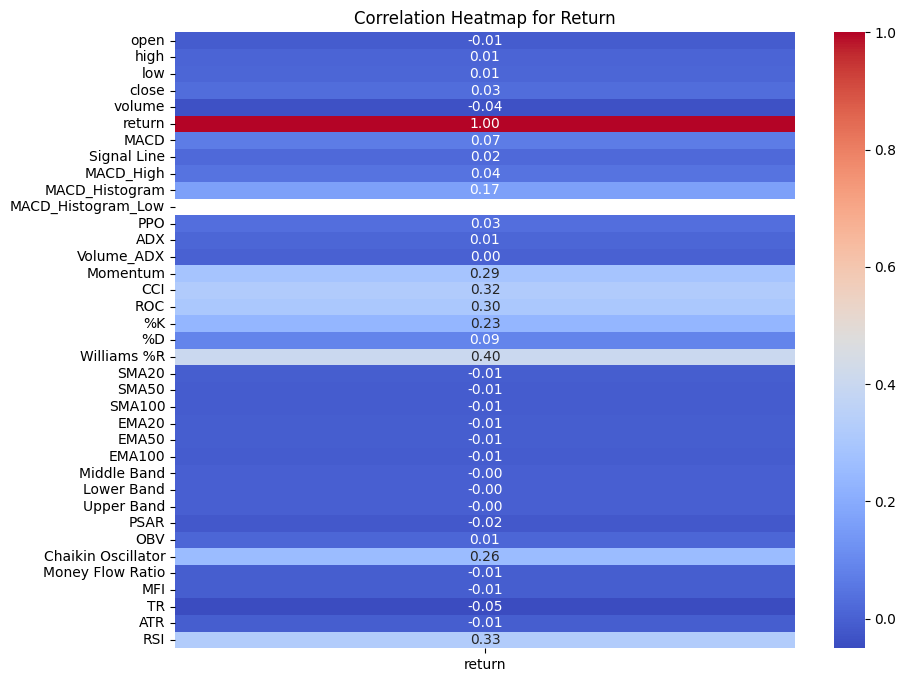

In [10]:
correlation_matrix = df.corr()
features_to_plot = ['return']
subset_corr_matrix = correlation_matrix[features_to_plot]

plt.figure(figsize=(10, 8))
sns.heatmap(subset_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap for Return')
plt.show()


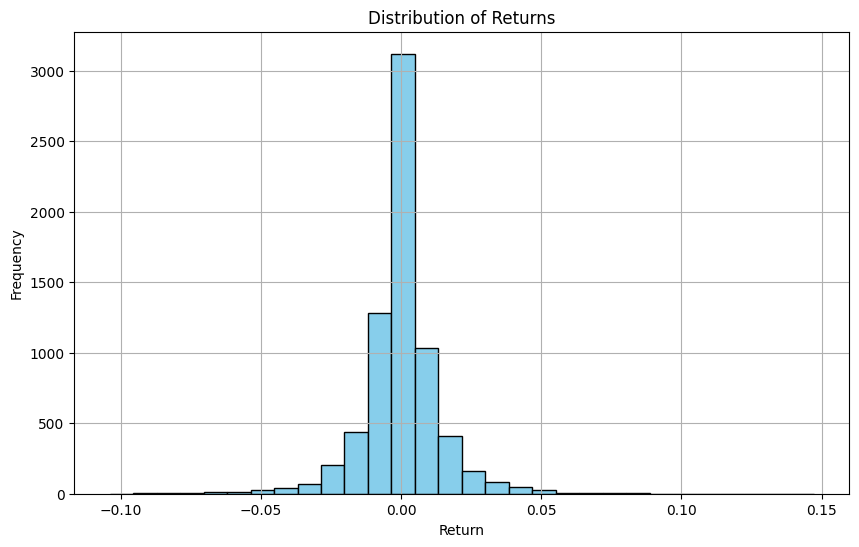

In [11]:
# 绘制返回率的直方图
plt.figure(figsize=(10, 6))
plt.hist(df['return'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Returns')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [12]:
return_stats = df['return'].describe()

print(return_stats)

count    6988.000000
mean        0.000194
std         0.013662
min        -0.103973
25%        -0.004831
50%         0.000158
75%         0.005063
max         0.147339
Name: return, dtype: float64


In [13]:

df.reset_index(inplace=True)
train_data, test_data = train_test_split(df, test_size=0.4, shuffle=False)

train_data.set_index('open_time', inplace=True)
test_data.set_index('open_time', inplace=True)

print("train data:", train_data.shape)
print("test data:", test_data.shape)


train data: (4192, 37)
test data: (2796, 37)


In [14]:
train_data

,open,high,low,close,volume,return,MACD,Signal Line,MACD_High,MACD_Histogram,...,Lower Band,Upper Band,PSAR,OBV,Chaikin Oscillator,Money Flow Ratio,MFI,TR,ATR,RSI
open_time,,,,,,,,,,,,,,,,,,,,,
2021-01-17 08:00:00,34787.76,35398.0,33863.50,35270.41,73668.710,0.013880,-297.791217,-24.756883,-24.756883,-273.034334,...,34510.953396,40034.538838,38210.770781,3.385586e+04,2535.620735,0.621030,38.310811,1534.50,1632.579286,43.244566
2021-01-17 12:00:00,35270.82,36000.0,34710.10,35749.53,53860.885,0.013584,-319.826869,-83.770880,-83.770880,-236.055989,...,34568.735314,39746.467320,37949.934534,8.771675e+04,19183.361072,0.556938,35.771363,1289.90,1634.072143,45.870927
2021-01-17 16:00:00,35744.90,36196.0,35561.00,35657.41,35568.074,-0.002577,-340.795122,-135.175728,-135.175728,-205.619394,...,34573.663521,39603.713068,37704.748462,5.214867e+04,16369.225835,0.561909,35.975770,635.00,1616.572143,45.435578
2021-01-17 20:00:00,35657.42,36898.0,35590.87,35869.83,38862.818,0.005957,-336.394350,-175.419453,-175.419453,-160.974898,...,34677.692634,39150.652645,37474.273554,9.101149e+04,6642.355071,0.525235,34.436325,1307.13,1502.868571,46.691952
2021-01-18 00:00:00,35875.72,36260.0,34875.00,35148.25,34971.262,-0.020117,-386.674836,-217.670529,-217.670529,-169.004306,...,34978.644452,38691.956444,37257.627141,5.604023e+04,-4677.257332,0.402716,28.709751,1385.00,1459.511429,43.064494
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-16 04:00:00,17418.80,17528.0,17365.40,17496.60,41640.970,0.004461,55.227117,112.451321,112.451321,-57.224204,...,17333.086169,18000.772236,18210.817690,-1.323991e+07,4063.930917,0.630424,38.666249,162.60,212.228571,50.699513
2022-12-16 08:00:00,17496.60,17510.5,16910.00,17018.60,188849.287,-0.027320,9.337347,91.828526,91.828526,-82.491179,...,17005.801678,18193.943969,18153.648628,-1.342876e+07,-28082.097413,0.697581,41.092661,600.50,248.307143,35.299892
2022-12-16 12:00:00,17018.70,17076.9,16870.60,16961.80,107277.504,-0.003338,-31.253639,67.212093,67.212093,-98.465733,...,16814.747036,18237.766051,18054.156738,-1.353604e+07,-42634.246496,0.656815,39.643219,206.30,257.192857,33.979133


In [15]:
X_train = train_data.drop(columns=["return"])
y_train = train_data["return"]

X_test = test_data.drop(columns=["return"])
y_test = test_data["return"]

model = XGBRegressor(
    objective='reg:squarederror',  
)

model.fit(X_train, y_train)
feature_importance = model.feature_importances_


feature_names = X_train.columns

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})

# 按重要性降序排序
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

top_20_features_df = feature_importance_df.head(20)

In [16]:
top_20_feature_names = top_20_features_df['Feature'].tolist()
print(top_20_feature_names)

['Williams %R', 'TR', '%D', 'RSI', 'PSAR', 'close', 'ATR', 'volume', 'MACD_Histogram', 'MACD', 'Lower Band', 'Upper Band', 'PPO', 'CCI', '%K', 'MACD_High', 'open', 'ADX', 'EMA100', 'Signal Line']


In [17]:
train_data['target'] = 1  # Initialize target column with zeros
train_data.loc[train_data['return'] > 0.03, 'target'] = 2  # Assign 1 where return is greater than 0.05
train_data.loc[train_data['return'] < -0.03, 'target'] = 0  # Assign -1 where return is less than -0.05

In [18]:
test_data['target'] = -1  # Initialize target column with zeros
test_data.loc[test_data['return'] > 0.03, 'target'] = 2  # Assign 1 where return is greater than 0.05
test_data.loc[test_data['return'] < -0.03, 'target'] = 0  # Assign -1 where return is less than -0.05

In [19]:
features_train = train_data[['Williams %R', 'TR', 'high', 'CCI', '%D', 'close', 
                             'PPO', 'SMA20', '%K', 'volume', 'RSI', 'ATR', 'MACD_Histogram', 
                             'open', 'MACD', 'ROC', 'Momentum', 'low', 'ADX', 'Chaikin Oscillator']].values
target_train = train_data[['target']].values

# Define parameter grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 2, 3],
    'subsample': [0.7, 0.8, 0.9],
    # 'colsample_bytree': [0.6, 0.7, 0.8],
    # 'gamma': [0, 0.1, 0.2],
    # 'reg_alpha': [0, 0.001, 0.01, 0.1, 1],
    # 'reg_lambda': [0, 0.001, 0.01, 0.1, 1],
}


# Initialize XGBClassifier
xgb = XGBClassifier(
    booster='gbtree',
    objective='binary:logistic',
    eval_metric='auc',
    n_estimators=100
)

# GridSearchCV 
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='accuracy',  # Using 'accuracy' as scoring metric
    cv=5,
    n_jobs=-1
)

# Fit the model
grid_search.fit(features_train, target_train)

# Print best parameters and scores
print("Best parameters found:", grid_search.best_params_)
print("Best accuracy found: ", grid_search.best_score_)

Best parameters found: {'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.7}
Best accuracy found:  0.9470451526280007


In [33]:

# best_params =  {'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.9} #4h0.03
# best_params =  {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 2, 'subsample': 0.7} #4h0.02
best_params =  {'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.7} #4h0.03
# best_params =  {'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.8} #4h0.05
# best_params =  {'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.8} #1d0.05
# best_params =  {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.7} #1d0.04
# best_params =  {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.7} #1d0.03
# best_params =  {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.7} #1d0.02

model = XGBClassifier(
    booster='gbtree',
    objective='binary:logistic',
    eval_metric='auc',
    n_estimators=100,
    **best_params
)

model.fit(features_train, target_train)

features_test = test_data[['Williams %R', 'TR', 'high', 'CCI', '%D', 'close', 
                             'PPO', 'SMA20', '%K', 'volume', 'RSI', 'ATR', 'MACD_Histogram', 
                             'open', 'MACD', 'ROC', 'Momentum', 'low', 'ADX', 'Chaikin Oscillator']].values
target_test = test_data['target'].values
y_pred = model.predict(features_test)

accuracy = accuracy_score(target_test, y_pred)
print("Accuracy on test set:", accuracy)

predicted_probabilities = model.predict_proba(features_test)
up = predicted_probabilities[:, 1]
down = predicted_probabilities[:, 0]
print("Probabilities of belonging to class 0 (fall):", down)
print("Probabilities of belonging to class 1 (rise):", up)
test_data['Predicted'] = y_pred
test_data['Probability_down'] = down
test_data['Probability_up'] = up

Accuracy on test set: 0.01072961373390558
Probabilities of belonging to class 0 (fall): [0.00127832 0.00054443 0.00070309 ... 0.00156201 0.00025124 0.00013213]
Probabilities of belonging to class 1 (rise): [0.99848586 0.9992113  0.99911505 ... 0.98468333 0.9989961  0.9994598 ]


In [21]:
test_data.columns

Index(['open', 'high', 'low', 'close', 'volume', 'return', 'MACD',
       'Signal Line', 'MACD_High', 'MACD_Histogram', 'MACD_Histogram_Low',
       'PPO', 'ADX', 'Volume_ADX', 'Momentum', 'CCI', 'ROC', '%K', '%D',
       'Williams %R', 'SMA20', 'SMA50', 'SMA100', 'EMA20', 'EMA50', 'EMA100',
       'Middle Band', 'Lower Band', 'Upper Band', 'PSAR', 'OBV',
       'Chaikin Oscillator', 'Money Flow Ratio', 'MFI', 'TR', 'ATR', 'RSI',
       'target', 'Predicted', 'Probability_down', 'Probability_up'],
      dtype='object')

In [22]:
importance = model.feature_importances_
feature_names = ['open', 'high', 'low', 'close', 'volume', 'MACD',
       'Signal Line', 'MACD_High', 'MACD_Histogram', 'MACD_Histogram_Low',
       'PPO', 'ADX', 'Volume_ADX', 'Momentum', 'CCI', 'ROC', '%K', '%D',
       'Williams %R', 'SMA20', 'SMA50', 'SMA100', 'EMA20', 'EMA50', 'EMA100',
       'Middle Band', 'Lower Band', 'Upper Band', 'PSAR', 'OBV',
       'Chaikin Oscillator', 'Money Flow Ratio', 'MFI', 'TR', 'ATR', 'RSI']

feature_importance_dict = dict(zip(feature_names, importance))
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

print("Feature Importances:")
for feature, importance in sorted_feature_importance:
    print(f"{feature}: {importance}")

Feature Importances:
high: 0.12410005927085876
%D: 0.09527067095041275
MACD_High: 0.07525485008955002
open: 0.07045412063598633
Momentum: 0.07041320949792862
MACD_Histogram_Low: 0.05356626957654953
volume: 0.04867112636566162
Signal Line: 0.04570604860782623
MACD: 0.04181062430143356
ADX: 0.041469234973192215
Volume_ADX: 0.03936217352747917
PPO: 0.03841676563024521
CCI: 0.03776891529560089
low: 0.03654257208108902
MACD_Histogram: 0.035464584827423096
%K: 0.032888222485780716
close: 0.03123905509710312
ROC: 0.029330512508749962
Williams %R: 0.026549434289336205
SMA20: 0.025721529498696327


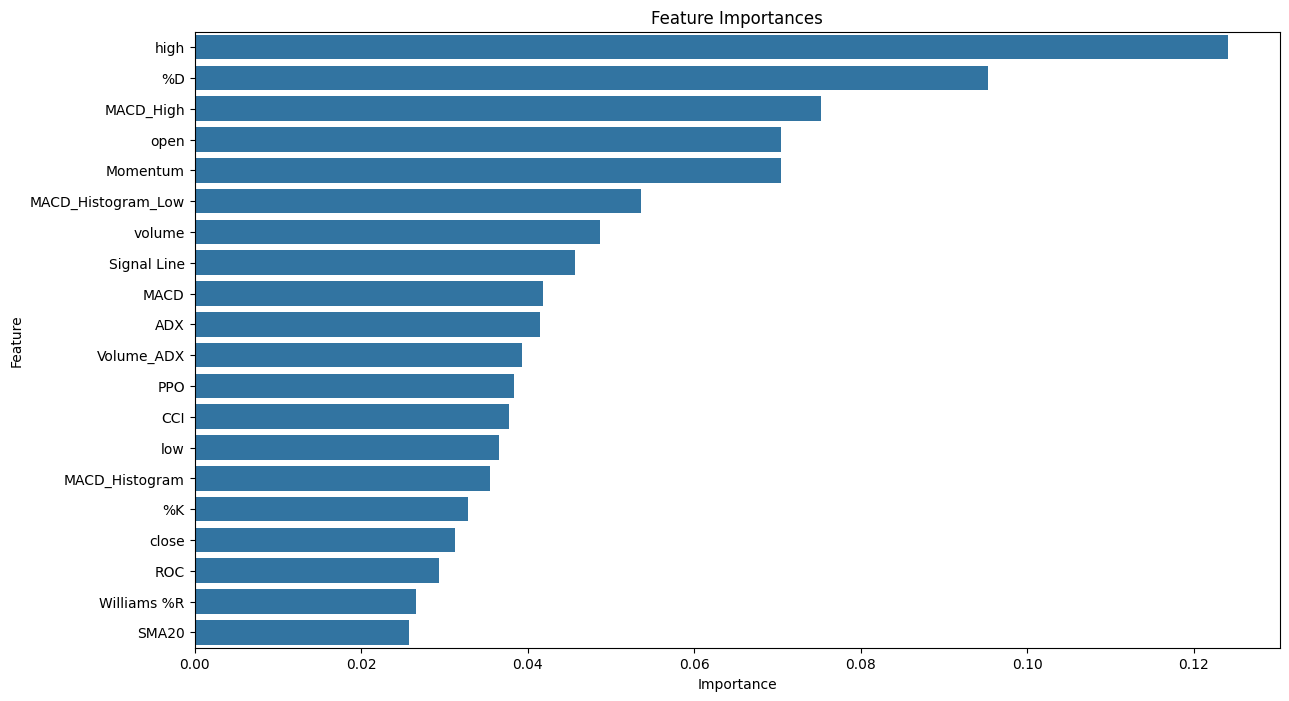

In [23]:
importance = model.feature_importances_
feature_names = ['open', 'high', 'low', 'close', 'volume', 'MACD',
                 'Signal Line', 'MACD_High', 'MACD_Histogram', 'MACD_Histogram_Low',
                 'PPO', 'ADX', 'Volume_ADX', 'Momentum', 'CCI', 'ROC', '%K', '%D',
                 'Williams %R', 'SMA20', 'SMA50', 'SMA100', 'EMA20', 'EMA50', 'EMA100',
                 'Middle Band', 'Lower Band', 'Upper Band', 'PSAR', 'OBV',
                 'Chaikin Oscillator', 'Money Flow Ratio', 'MFI', 'TR', 'ATR', 'RSI']

feature_importance_dict = dict(zip(feature_names, importance))
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

features = [x[0] for x in sorted_feature_importance]
importances = [x[1] for x in sorted_feature_importance]

plt.figure(figsize=(14, 8))
sns.barplot(x=importances, y=features)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [24]:
test_data['status'] = test_data['Predicted'].shift(1).fillna(0)

test_data['buy_cost'] = test_data.open[((test_data.status == 2) & (test_data.status.shift(1) == 0)) | ((test_data.status == 2) & (test_data.status.shift(1) == 1))]
test_data['sell_cost'] = test_data.open[((test_data.status == 0) & (test_data.status.shift(1) == 1)) | ((test_data.status == 0) & (test_data.status.shift(1) == 2))]
test_data = test_data.fillna(0)

buy_cost = np.array(test_data.loc[test_data['buy_cost'] != 0, 'buy_cost'])
sell_price = np.array(test_data.loc[test_data['sell_cost'] != 0, 'sell_cost'])

if len(buy_cost) > len(sell_price):
    buy_cost = buy_cost[:len(sell_price)]

trade_return = sell_price / buy_cost - 1

fee = 0.002
net_trade_return = trade_return - fee

# 將報酬率放進表格中
test_data['trade_ret'] = 0.0  
test_data['net_trade_ret'] = 0.0  
sell_dates = test_data.sell_cost[test_data.sell_cost != 0].index
test_data.loc[sell_dates, 'trade_ret'] = trade_return
test_data.loc[sell_dates, 'net_trade_ret'] = net_trade_return

buy_dates = test_data[test_data['status'] == 2].index
sell_dates = test_data[test_data['status'] == 0].index

In [25]:
test_data['open_ret'] = test_data['open'] / test_data['open'].shift(1) - 1
test_data['strategy_ret'] = test_data['status'].shift(1) * test_data['open_ret']
test_data['strategy_net_ret'] = test_data['strategy_ret']
test_data.loc[sell_dates, 'strategy_net_ret'] = test_data.loc[sell_dates, 'strategy_net_ret'] - fee
test_data = test_data.fillna(0)

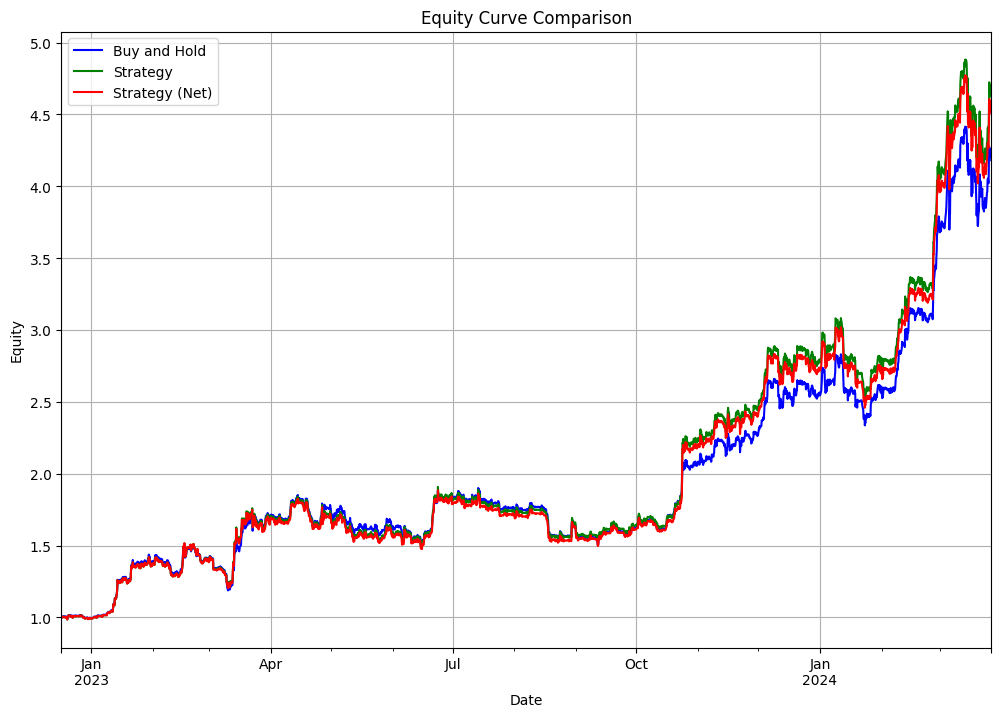

In [26]:
test_data['open_ret'] = test_data['open'] / test_data['open'].shift(1) - 1
test_data['buy_and_hold_equity'] = (test_data['open_ret'] + 1).cumprod()
test_data['strategy_equity'] = (test_data['strategy_ret'] + 1).cumprod()
test_data['strategy_net_equity'] = (test_data['strategy_net_ret'] + 1).cumprod()

plt.figure(figsize=(12, 8))
test_data['buy_and_hold_equity'].plot(label='Buy and Hold', color='blue')
test_data['strategy_equity'].plot(label='Strategy', color='green')
test_data['strategy_net_equity'].plot(label='Strategy (Net)', color='red')


plt.title('Equity Curve Comparison')
plt.xlabel('Date')
plt.ylabel('Equity')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
test_data['equity'] = test_data['strategy_net_equity']
test_data['drawdown_percent'] = (test_data['equity'] / test_data['equity'].cummax()) - 1
test_data['drawdown'] = test_data['equity'] - test_data['equity'].cummax()
mdd = abs(test_data['drawdown_percent'].min())

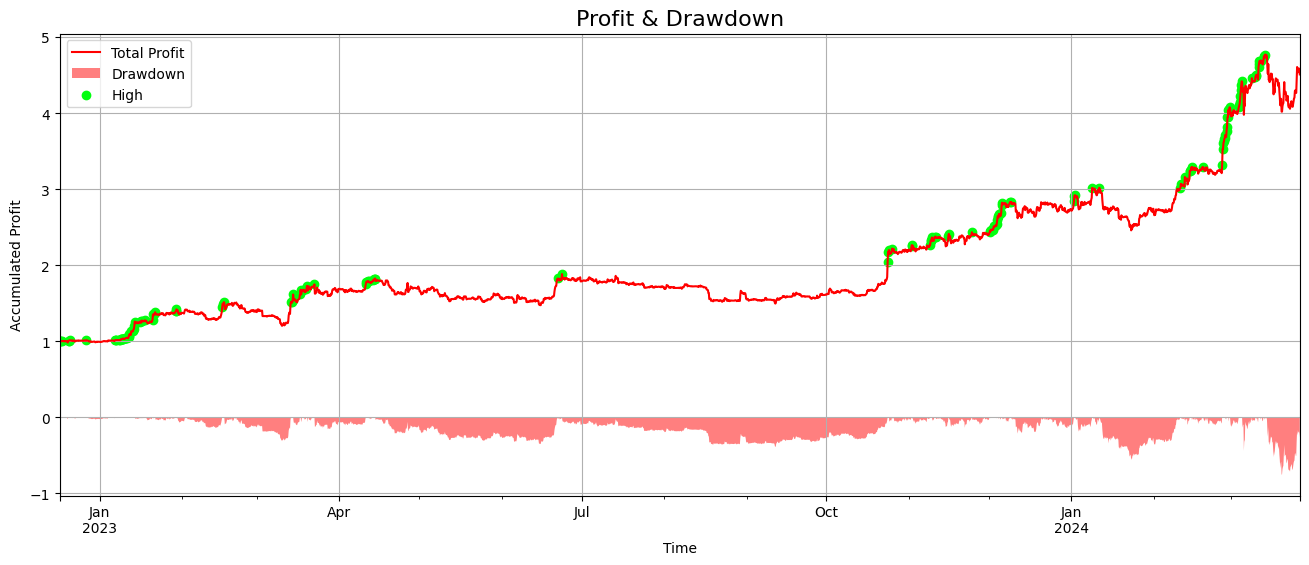

In [28]:
fig, ax = plt.subplots(figsize=(16, 6))

high_index = test_data[test_data['strategy_net_equity'].cummax() == test_data['strategy_net_equity']].index
test_data['strategy_net_equity'].plot(label='Total Profit', ax=ax, c='r', grid=True)
plt.fill_between(test_data['drawdown'].index, test_data['drawdown'], 0, facecolor='r', label='Drawdown', alpha=0.5)
plt.scatter(high_index, test_data['strategy_net_equity'].loc[high_index], c='#02ff0f', label='High')

plt.legend()
plt.ylabel('Accumulated Profit')
plt.xlabel('Time')
plt.title('Profit & Drawdown', fontsize=16)
plt.show()


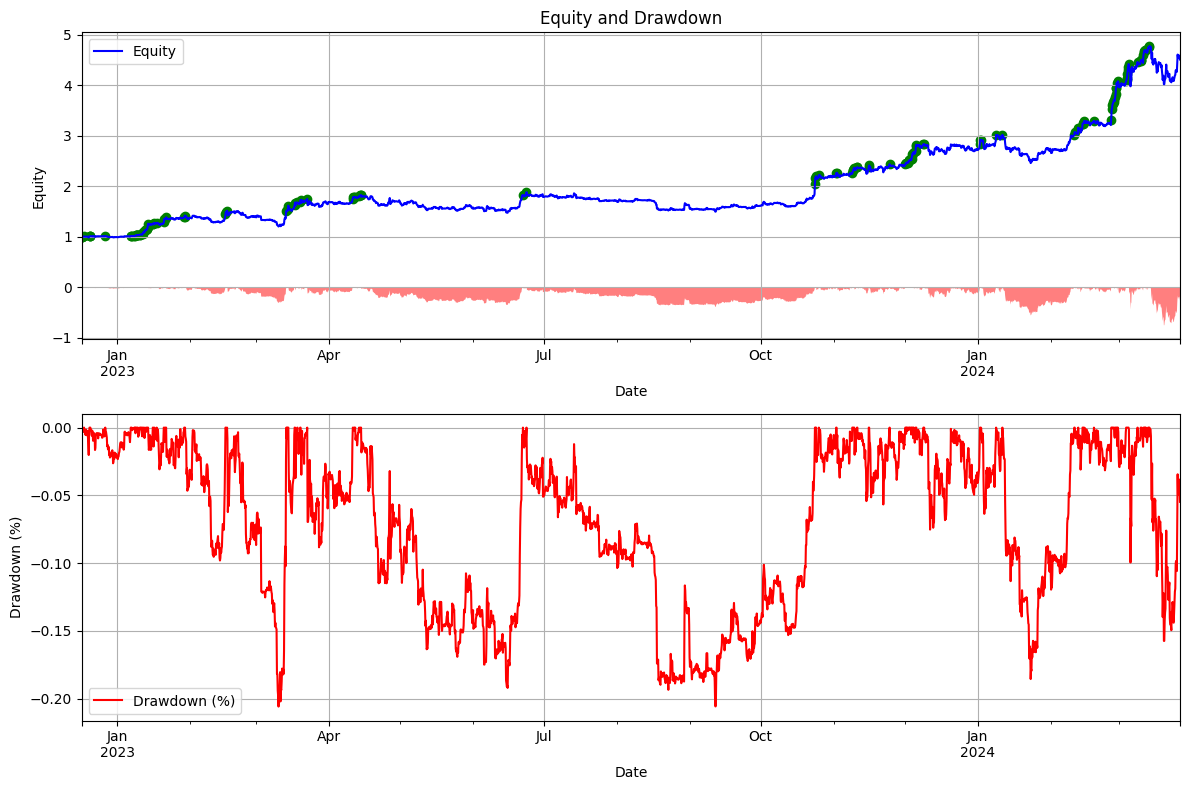

In [29]:
plt.figure(figsize=(12, 8))

# Plot Equity
plt.subplot(2, 1, 1)
test_data['equity'].plot(label='Equity', color='blue')
plt.title('Equity and Drawdown')
plt.xlabel('Date')
plt.ylabel('Equity')
plt.legend()
plt.grid(True)

# Highlight High Index
high_index = test_data[test_data['strategy_net_equity'].cummax() == test_data['strategy_net_equity']].index
plt.scatter(high_index, test_data.loc[high_index, 'equity'], color='green', label='High Index')

# Plot Drawdown as Filled Area
plt.fill_between(test_data['drawdown'].index, test_data['drawdown'], 0, facecolor='red', label='Drawdown', alpha=0.5)

# Plot Drawdown
plt.subplot(2, 1, 2)
test_data['drawdown_percent'].plot(label='Drawdown (%)', color='red')
plt.xlabel('Date')
plt.ylabel('Drawdown (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


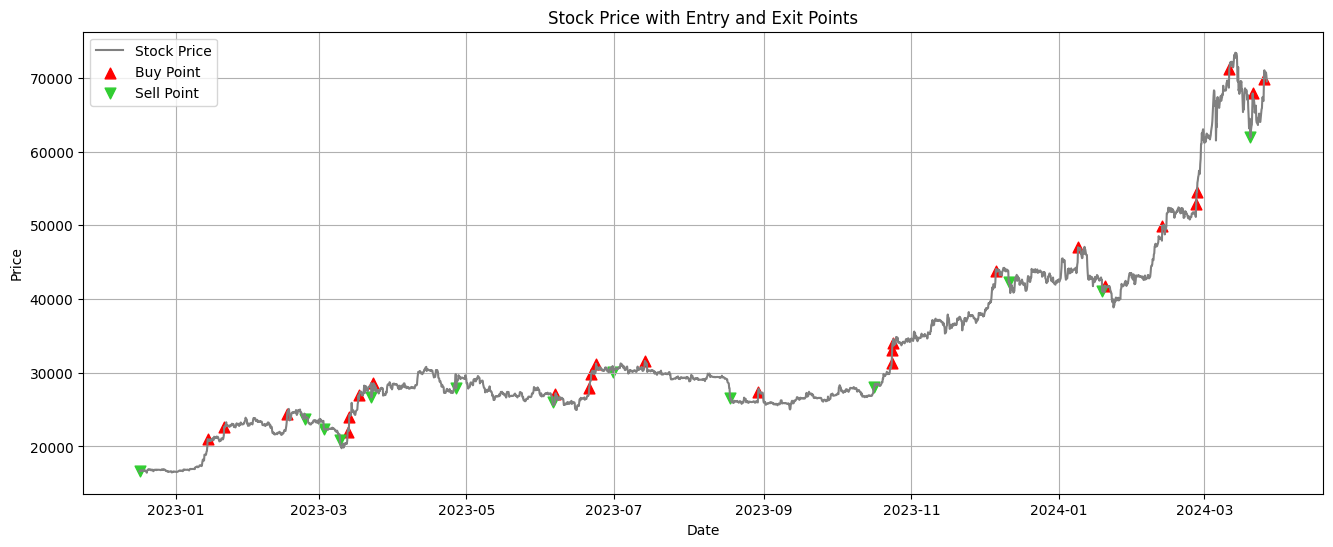

In [31]:
plt.figure(figsize=(16, 6))

# Plot Stock Price
plt.plot(test_data.index, test_data['open'], label='Stock Price', color='gray')

# Plot Entry and Exit Points
buy_points = test_data[test_data['status'] == 2].index
sell_points = test_data[test_data['status'] == 0].index
plt.scatter(buy_points, test_data.loc[buy_points, 'open'], color='red', marker='^', label='Buy Point', s=60)
plt.scatter(sell_points, test_data.loc[sell_points, 'open'], color='limegreen', marker='v', label='Sell Point', s=60)

plt.title('Stock Price with Entry and Exit Points')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


In [32]:
strategy_net_ret = test_data['strategy_net_ret']
profit = test_data['strategy_net_equity'].iloc[-1]
ret = test_data['equity'].iloc[-1] / test_data['equity'].iloc[0] - 1
mdd = abs(test_data['drawdown_percent'].min())
calmarRatio = ret / mdd
trade_times = len(buy_dates) + len(sell_dates)
win_rate = (strategy_net_ret > 0).sum() / trade_times
profit_factor = strategy_net_ret[strategy_net_ret > 0].sum() / abs(strategy_net_ret[strategy_net_ret < 0].sum())
winLossRatio = np.mean([i for i in strategy_net_ret if i > 0]) / abs(np.mean([i for i in strategy_net_ret if i < 0]))
arholdingperiod = (test_data.index[-1] - test_data.index[0]) / trade_times
strategy_ear = test_data['strategy_net_equity'].iloc[-1] ** (252 / len(test_data)) - 1
strategy_std = test_data.strategy_net_ret.std() * (252 ** 0.5)
strategy_sharpe = (strategy_ear - 0.01) / strategy_std


print(f'profit: ${np.round(profit,2)}')
print(f'return: {np.round(ret,4)*100}%')
print(f'Annualized Return: {np.round(strategy_ear * 100, 2)}%')
print(f'Annualized ST deviation: {np.round(strategy_std * 100, 2)}%')
print(f'mdd: {np.round(mdd,4)*100}%')
print(f'calmarRatio: {np.round(calmarRatio,2)}')
print(f'tradeTimes: {trade_times}')
# print(f'winRate: {np.round(win_rate,4)*100}%')
print(f'profitFactor: {np.round(profit_factor,2)}')
print(f'winLossRatio: {np.round(winLossRatio,2)}')
print(f'averageholdingperiod: {arholdingperiod}')
print(f'Sharpe Ratio: {np.round(strategy_sharpe, 2)}')




profit: $4.51
return: 351.05%
Annualized Return: 14.54%
Annualized ST deviation: 15.68%
mdd: 20.59%
calmarRatio: 17.05
tradeTimes: 38
profitFactor: 1.22
winLossRatio: 1.11
averageholdingperiod: 12 days 06:12:37.894736842
Sharpe Ratio: 0.86
